# Introduction
This project aims to train a model to predict under which conditions might a steel production line machine fail. This model is trained on data from Tata Steel production plants.

## Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILEPATH = '/content/drive/My Drive/AB Capstone Project 6/'

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [4]:
train_df = pd.read_csv(FILEPATH+'train.csv')
train_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [5]:
test_df = pd.read_csv(FILEPATH+'test.csv')
test_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


# Preprocessing

## EDA

In [8]:
# check for null values
train_df.isna().sum()

,0
id,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


In [9]:
test_df.isna().sum()

,0
id,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
TWF,0
HDF,0


In [12]:
train_df.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
test_df.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.00000,90954.000000
mean,181905.500000,299.859493,309.939375,1520.528179,40.335191,104.293962,0.001473,0.005343,0.002353,0.00387,0.002309
std,26256.302529,1.857562,1.385296,139.970419,8.504683,63.871092,0.038355,0.072903,0.048449,0.06209,0.047995
min,136429.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,159167.250000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,181905.500000,300.000000,310.000000,1493.000000,40.500000,106.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,204643.750000,301.200000,310.900000,1579.000000,46.200000,158.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,227382.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.00000,1.000000


The variable-wise standard deviation values for the both the sets are very close to each other.</br>
Both kelvin values have std of close to 1, this means there's not much variation in temperature values.</br>
The other numerical columns, however, have higher variation.

In [25]:
train_df['Machine failure'].value_counts()

,count
Machine failure,
0,134281
1,2148


The number of failed records are just 1.5% of the total dataset. Drastically low.

Distribution of numerical columns

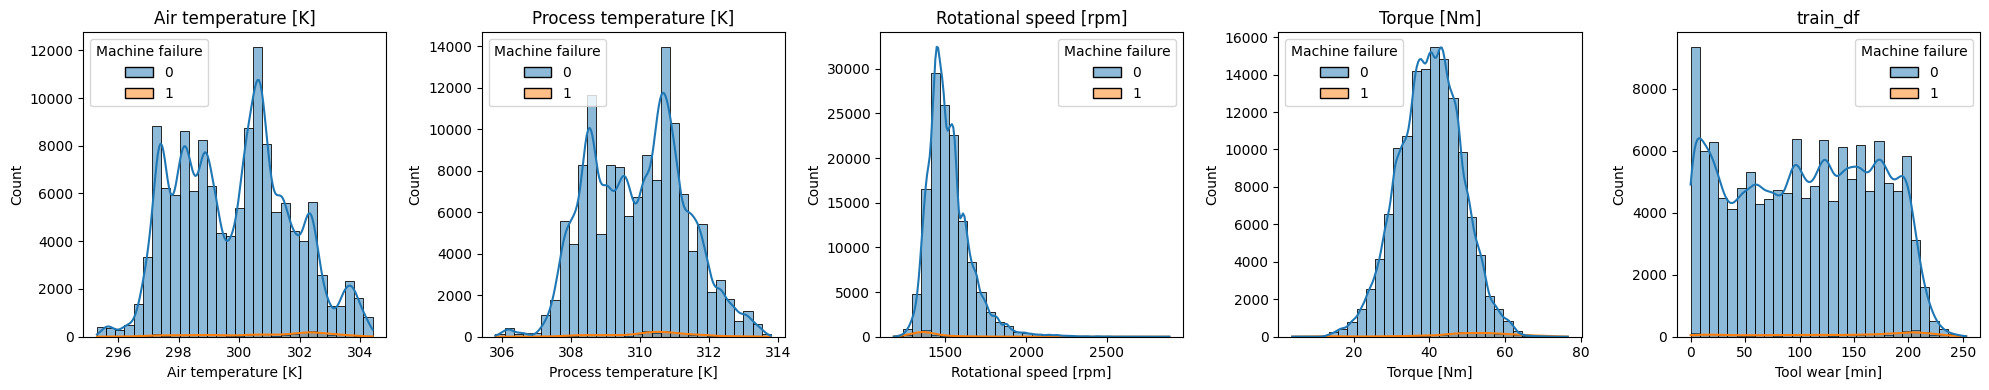

In [24]:
cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, col in zip(axes, cols):
  sns.histplot(data=train_df, x=col, ax=ax, bins=30, kde=True, hue='Machine failure')
  ax.set_title(col)

plt.title('train_df')
plt.tight_layout()
plt.show()

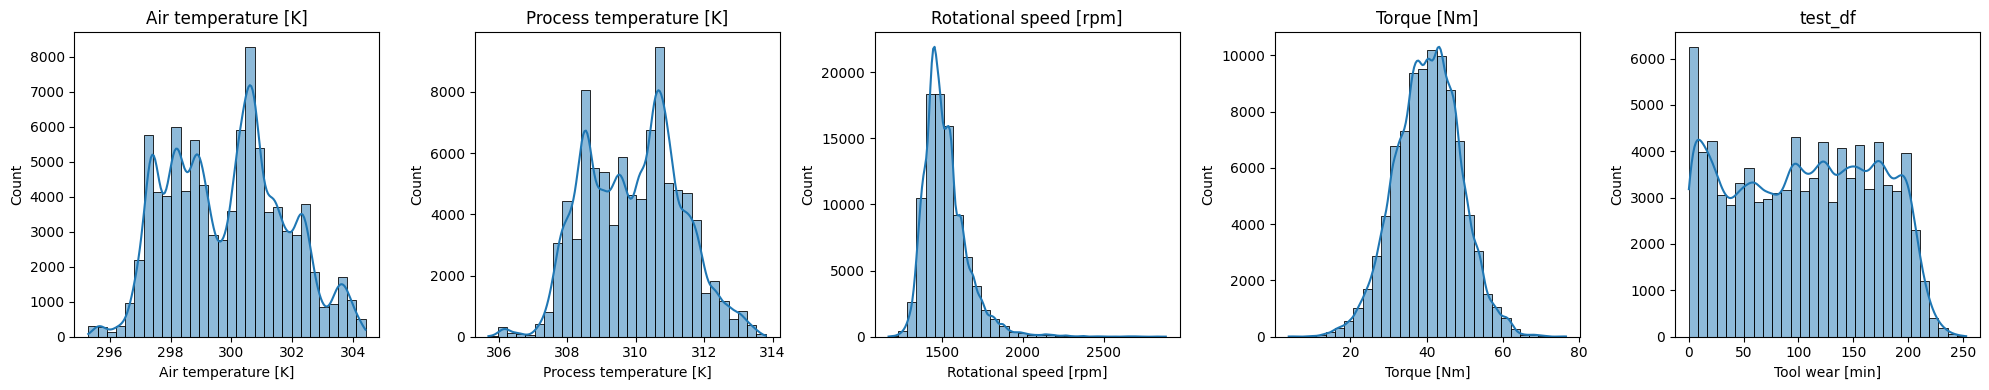

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, col in zip(axes, cols):
  sns.histplot(data=test_df, x=col, ax=ax, bins=30, kde=True)
  ax.set_title(col)

plt.title('test_df')
plt.tight_layout()
plt.show()

## Feature Encoding
Converting categorical column, Type, using ordinal numerical values

In [27]:
mapping = {'L': 1, 'M': 2, 'H': 3}

train_df['type_encoded'] = train_df['Type'].map(mapping)
train_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,type_encoded
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,1
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,2
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,1
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,1
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,2


In [28]:
test_df['type_encoded'] = test_df['Type'].map(mapping)
test_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,type_encoded
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0,1
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0,1
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0,1
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0,2
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0,2


## Feature Selection
Extracting the useful features

In [31]:
train = train_df[['type_encoded', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure']]
test = test_df[['type_encoded', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

In [32]:
train.head()

,type_encoded,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],TWF,HDF,PWF,OSF,RNF,Machine failure
0,1,300.6,309.6,1596,36.1,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,0,0,0,0,0,0
3,1,301.0,310.9,1524,44.3,0,0,0,0,0,0
4,2,298.0,309.0,1641,35.4,0,0,0,0,0,0


In [33]:
test.head()

,type_encoded,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],TWF,HDF,PWF,OSF,RNF
0,1,302.3,311.5,1499,38.0,0,0,0,0,0
1,1,301.7,311.0,1713,28.8,0,0,0,0,0
2,1,301.3,310.4,1525,37.7,0,0,0,0,0
3,2,300.1,309.6,1479,47.6,0,0,0,0,0
4,2,303.4,312.3,1515,41.3,0,0,0,0,0


## Scaling
Scaling the numerical columns so that they share the same range.</br>This will improve the model's performance.</br></br> Standard scaling is being used, which centers the data around 0 & squeezes them to make the standard deviation 1.

In [34]:
scaler = StandardScaler()

In [39]:
train.head()

,type_encoded,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],TWF,HDF,PWF,OSF,RNF,Machine failure
0,1,300.6,309.6,1596,36.1,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,0,0,0,0,0,0
3,1,301.0,310.9,1524,44.3,0,0,0,0,0,0
4,2,298.0,309.0,1641,35.4,0,0,0,0,0,0


In [40]:
cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']
train[cols] = scaler.fit_transform(train[cols])
train.head()

/tmp/ipython-input-3530336747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cols] = scaler.fit_transform(train[cols])


,type_encoded,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],TWF,HDF,PWF,OSF,RNF,Machine failure
0,1,0.395880,-0.246230,0.545416,-0.499711,0,0,0,0,0,0
1,2,1.469856,1.558605,1.720308,-1.323028,0,0,0,0,0,0
2,1,-0.302204,-1.040358,2.051873,-1.628831,0,0,0,0,0,0
3,1,0.610675,0.692284,0.026445,0.464745,0,0,0,0,0,0
4,2,-1.000288,-0.679391,0.869773,-0.582043,0,0,0,0,0,0


In [41]:
X = train.drop(columns=['Machine failure'])
y = train['Machine failure']

# Training Models
This is where we train our models on cleaned data

## Logistic Regression

Define the logistic regression model and define cross-validation folds.</br>I'm using stratified cross validation because of target variable is highly imbalanced.

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=2000,
    solver="lbfgs"
)

This is where we try to find the optimum model across all the defined parameters.

In [44]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_lr.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

Select the best performing model. GridSearch refits to the entire training set by default.</br>Compute `training scores`.

In [45]:
best_lr = grid_lr.best_estimator_

roc_auc = grid_lr.best_score_
f1 = cross_val_score(
    best_lr,
    X,
    y,
    cv=cv,
    scoring="f1"
).mean()

Store the `training scores` in a df.

In [82]:
metrics_df = pd.DataFrame({
    "model": ["Logistic Regression"],
    "roc_auc": [roc_auc],
    "f1_score": [f1]
})

metrics_df

,model,roc_auc,f1_score
0,Logistic Regression,0.932329,0.611882


## Random Forest

We'll repeat the process, of obtaining the best model through grid search cv, again.

Define the randome forest classifier object, without critical hyperparameters.

In [48]:
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

Define a parameter space where our grid search will operate.

In [54]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10],
    "min_samples_leaf": [1, 5]
}

In [55]:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,
    verbose=1
)

grid_rf.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [10], 'min_samples_leaf': [1, 5],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=1)

In [56]:
best_rf = grid_rf.best_estimator_

roc_auc_rf = grid_rf.best_score_
f1_rf = cross_val_score(
    best_rf,
    X,
    y,
    cv=cv,
    scoring="f1"
).mean()

In [83]:
# rf_results = pd.DataFrame({
#     "model": ["Random Forest"],
#     "roc_auc": [roc_auc_rf],
#     "f1_score": [f1_rf]
# })

row = ['Random Forest', roc_auc_rf, f1_rf]

metrics_df.loc[len(metrics_df)] = row

metrics_df

,model,roc_auc,f1_score
0,Logistic Regression,0.932329,0.611882
1,Random Forest,0.957188,0.551140


## XGBoost

Before implementation, we need to rename our columns & remove the instances of `[` & `]`.

In [65]:
X.rename(columns={
    'Air temperature [K]': 'air_temp_k',
    'Process temperature [K]': 'process_temp_k',
    'Rotational speed [rpm]': 'rotational_speed_rpm',
    'Torque [Nm]': 'torque_nm'
}, inplace=True)

X.head()

,type_encoded,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,TWF,HDF,PWF,OSF,RNF
0,1,0.395880,-0.246230,0.545416,-0.499711,0,0,0,0,0
1,2,1.469856,1.558605,1.720308,-1.323028,0,0,0,0,0
2,1,-0.302204,-1.040358,2.051873,-1.628831,0,0,0,0,0
3,1,0.610675,0.692284,0.026445,0.464745,0,0,0,0,0
4,2,-1.000288,-0.679391,0.869773,-0.582043,0,0,0,0,0


Same procedure here

In [62]:
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=1,
    use_label_encoder=False
)

In [61]:
param_grid = {
    "n_estimators": [50, 75],
    "max_depth": [2, 4],
    "learning_rate": [0.05, 0.1],
    # "subsample": [0.8, 1.0],
    # "colsample_bytree": [0.8, 1.0]
}

In [66]:
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:36:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_poli...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 4],
                         'n_estimators': [50, 75]},
             scoring='roc_auc', verbose=1)

In [67]:
best_xgb = grid_xgb.best_estimator_

roc_auc_xgb = grid_xgb.best_score_
f1_xgb = cross_val_score(
    best_xgb,
    X,
    y,
    cv=cv,
    scoring="f1"
).mean()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:36:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:36:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:36:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:37:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:37:01] WARNING: /w

In [84]:
row = ['XGBoost', roc_auc_xgb, f1_xgb]

metrics_df.loc[len(metrics_df)] = row

metrics_df

,model,roc_auc,f1_score
0,Logistic Regression,0.932329,0.611882
1,Random Forest,0.957188,0.551140
2,XGBoost,0.956605,0.445900


## Training Evaluation
We compare how each model performed in it's training.</br>
**NOTE:** This is not the final evaluation score, just are just the training scores.

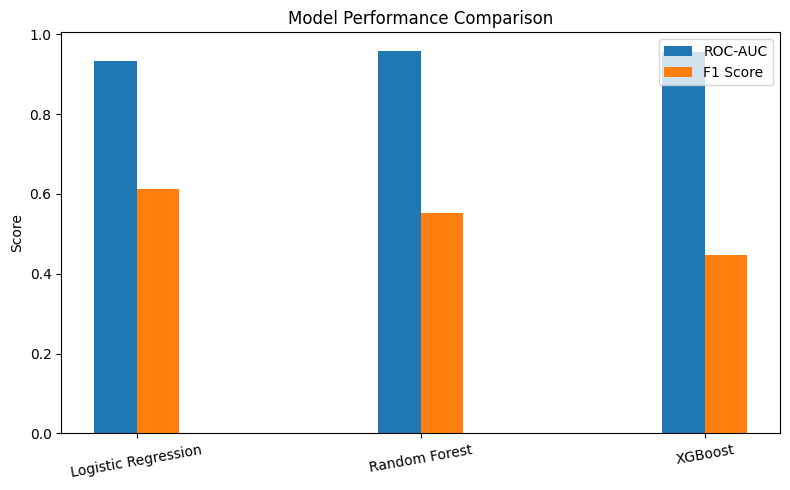

In [85]:
x = np.arange(len(metrics_df))
width = 0.15

# plot
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, metrics_df["roc_auc"], width, label="ROC-AUC")
plt.bar(x + width/2, metrics_df["f1_score"], width, label="F1 Score")

# labels
plt.xticks(x, metrics_df["model"], rotation=10)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# Failure Prediction

Now that we have three classification models, we predict the possible failure states of the records in the test set.</br></br>
**NOTE:** The test set does not have the `target variable` inside it, so it's not possible to calculate the accurace, the ACTUAL accuracy of these models.</br>
We can still, however, predict the furture states.

First we need to appropriately scale the test set.

## Scaling

In [86]:
test.head()

,type_encoded,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],TWF,HDF,PWF,OSF,RNF
0,1,302.3,311.5,1499,38.0,0,0,0,0,0
1,1,301.7,311.0,1713,28.8,0,0,0,0,0
2,1,301.3,310.4,1525,37.7,0,0,0,0,0
3,2,300.1,309.6,1479,47.6,0,0,0,0,0
4,2,303.4,312.3,1515,41.3,0,0,0,0,0


In [87]:
cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']
test[cols] = scaler.transform(test[cols])
test.head()

/tmp/ipython-input-2255016250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[cols] = scaler.transform(test[cols])


,type_encoded,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],TWF,HDF,PWF,OSF,RNF
0,1,1.308759,1.125444,-0.153753,-0.276240,0,0,0,0,0
1,1,0.986567,0.764477,1.388744,-1.358313,0,0,0,0,0
2,1,0.771772,0.331317,0.033653,-0.311525,0,0,0,0,0
3,2,0.127386,-0.246230,-0.297912,0.852880,0,0,0,0,0
4,2,1.899446,1.702992,-0.038426,0.111895,0,0,0,0,0


## Prediction

In [93]:
# empty dataset
pred_df = pd.DataFrame(index=test.index)

pred_df["lr_pred"] = best_lr.predict(test)
pred_df["rf_pred"] = best_rf.predict(test)

pred_df.head()

,lr_pred,rf_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [94]:
test.rename(columns={
    'Air temperature [K]': 'air_temp_k',
    'Process temperature [K]': 'process_temp_k',
    'Rotational speed [rpm]': 'rotational_speed_rpm',
    'Torque [Nm]': 'torque_nm'
}, inplace=True)

test.head()

/tmp/ipython-input-2334113804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={


,type_encoded,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,TWF,HDF,PWF,OSF,RNF
0,1,1.308759,1.125444,-0.153753,-0.276240,0,0,0,0,0
1,1,0.986567,0.764477,1.388744,-1.358313,0,0,0,0,0
2,1,0.771772,0.331317,0.033653,-0.311525,0,0,0,0,0
3,2,0.127386,-0.246230,-0.297912,0.852880,0,0,0,0,0
4,2,1.899446,1.702992,-0.038426,0.111895,0,0,0,0,0


In [95]:
pred_df['xgb_pred'] = best_xgb.predict(test)

pred_df.head()

,lr_pred,rf_pred,xgb_pred
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


# Conclusion

`pred_df` has the final list of predictions made by our model.</br>It can be exported into a `.csv` file.

In [96]:
pred_df.to_csv(FILEPATH+'final_predictions.csv')